In [1]:
import pandas as pd
import numpy as np
from scipy.stats import binom

np.random.seed(37)

N = 1_000

X = np.random.binomial(1, 0.1, N)
H = binom.rvs(1, 1 / (1 + np.exp(-(0.1 + 2.3 * X))))
Y = binom.rvs(1, 1 / (1 + np.exp(-(0.1 + 2.3 * X - 3.4 * H))))

Xy = pd.DataFrame({'X': np.random.binomial(1, 0.1, N)}) \
    .assign(H=lambda d: binom.rvs(1, 1 / (1 + np.exp(-(1.3 * d['X']))))) \
    .assign(Y=lambda d: binom.rvs(1, 1 / (1 + np.exp(-(2.3 * d['X'] + 0.5 * d['H'])))))

Xy.shape

(1000, 3)

In [2]:
Xy.head()

,X,H,Y
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,1,0,1


In [12]:
from sklearn.ensemble import RandomForestClassifier

X = Xy[['X', 'H']]
y = Xy['Y']

m = RandomForestClassifier(n_jobs=-1, random_state=37).fit(X, y)

pd.Series(m.feature_importances_, X.columns)

X    0.749739
H    0.250261
dtype: float64

In [10]:
from sklearn.ensemble import RandomForestRegressor

A = Xy[['X', 'H', 'Y']]
b = y - m.predict_proba(X)[:,1]

u = RandomForestRegressor(n_jobs=-1, random_state=37).fit(A, b)

pd.Series(u.feature_importances_, A.columns)

X    0.061349
H    0.016505
Y    0.922145
dtype: float64

<Axes: xlabel='y', ylabel='b'>

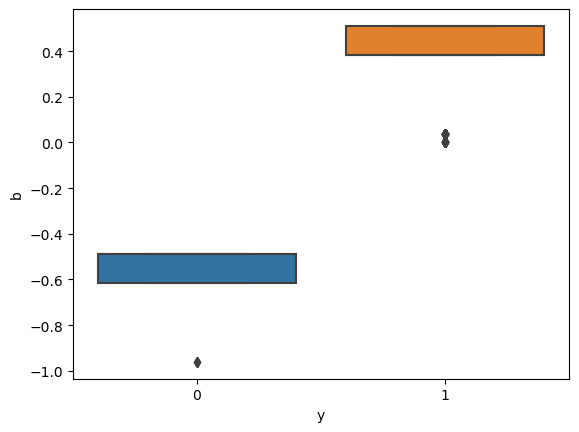

In [5]:
import seaborn as sns

sns.boxplot(data=pd.DataFrame({'y': y, 'b': b}), x='y', y='b')

In [6]:
def to_df(v, c):
    return pd.DataFrame([v], columns=c)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)



In [7]:
x, h, y = 1, 1, 1

y_f = m.predict_proba(to_df([x, h], ['X', 'H']))[0]
u_y = u.predict(to_df([x, h, y], ['X', 'H', 'Y']))[0]
y_pred = m.predict_proba(to_df([x, 0], ['X', 'H']))[0]

pd.DataFrame(
    [y_f, [u_y, u_y], y_pred, y_pred + u_y, softmax(y_pred + u_y)],
    columns=['y=0', 'y=1'],
    index=['y_f', 'u_y', 'y_pred', 'y_cf', 'y_cf*']
)

,y=0,y=1
y_f,0.039008,0.960992
u_y,0.039008,0.039008
y_pred,0.000000,1.000000
y_cf,0.039008,1.039008
y_cf*,0.268941,0.731059


In [8]:
x, h, y = 1, 0, 1

y_f = m.predict_proba(to_df([x, h], ['X', 'H']))[0]
u_y = u.predict(to_df([x, h, y], ['X', 'H', 'Y']))[0]
y_pred = m.predict_proba(to_df([1, 1], ['X', 'H']))[0]

pd.DataFrame(
    [y_f, [u_y, u_y], y_pred, y_pred + u_y, softmax(y_pred + u_y)],
    columns=['y=0', 'y=1'],
    index=['y_f', 'u_y', 'y_pred', 'y_cf', 'y_cf*']
)

,y=0,y=1
y_f,0.000000,1.000000
u_y,0.000000,0.000000
y_pred,0.039008,0.960992
y_cf,0.039008,0.960992
y_cf*,0.284554,0.715446
